In [100]:
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload 
%autoreload 2

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import math

from utils import *

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# load data
train_df = pd.read_csv("./dataset/algerian_fires_train.csv")
test_df = pd.read_csv("./dataset/algerian_fires_test.csv")
test_y = test_df.loc[:, 'Classes'].values
train_idx = np.arange(train_df.shape[0])
test_idx = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
df = pd.concat([train_df, test_df], axis=0).reset_index().drop(columns=['index'])
df.loc[test_idx, 'Classes'] = -1
df.tail(3)
df.info()

Date  Temperature         RH         Ws      Rain       FFMC  \
241  29/09/2012    37.339703  52.937815  16.205994  1.912920  38.312370   
242  30/09/2012    15.564590  95.993971  10.151700  1.706248  28.532177   
243  30/09/2012    28.086910  78.559730  20.526848  0.000308  76.508336   

          DMC         DC       ISI       BUI  Classes  
241 -1.201162   6.693217 -1.625460  3.574448       -1  
242 -4.114930   7.287113 -1.112841 -2.839438       -1  
243 -2.569310  22.049612  2.447567 -1.100239       -1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         244 non-null    object 
 1   Temperature  244 non-null    float64
 2   RH           244 non-null    float64
 3   Ws           244 non-null    float64
 4   Rain         244 non-null    float64
 5   FFMC         244 non-null    float64
 6   DMC          244 non-null    float64
 7   DC           244 non-null    float64
 8   ISI          244 non-null    float64
 9   BUI          244 non-null    float64
 10  Classes      244 non-null    int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 21.1+ KB


## **Data Process**

In [102]:
# feature normalization
Date_col = 'Date'
tar_col = 'Classes'
feat_cols = [col for col in train_df.columns if col != Date_col and col != tar_col]

df.loc[:, feat_cols] = (df.loc[:, feat_cols] - df.loc[:, feat_cols].mean(axis=0)) / (df.loc[:, feat_cols].std(axis=0) + 1e-8)
df.head(3)

Date  Temperature        RH        Ws      Rain      FFMC       DMC  \
0  01/06/2012    -1.428822 -0.827333 -0.650548 -0.542151 -0.173436 -1.286009   
1  01/06/2012     0.227105 -0.718350 -0.141711  0.086637 -0.852555 -1.069184   
2  02/06/2012    -1.822265 -0.220204 -0.915161  0.311761 -1.765988 -0.841802   

         DC       ISI       BUI  Classes  
0 -0.410135 -0.955678 -0.695594        0  
1 -1.191452 -1.397439 -0.966293        0  
2 -1.267797 -0.763704 -1.349082        0

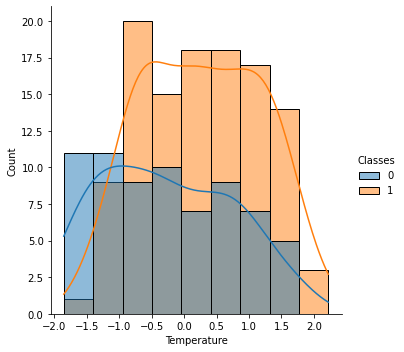

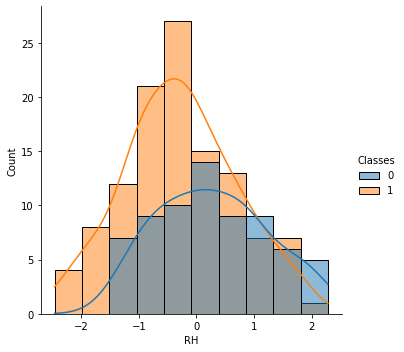

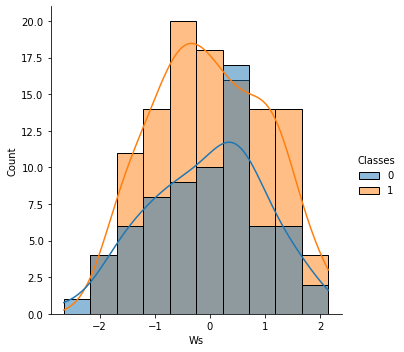

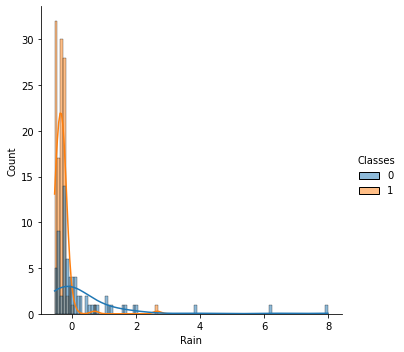

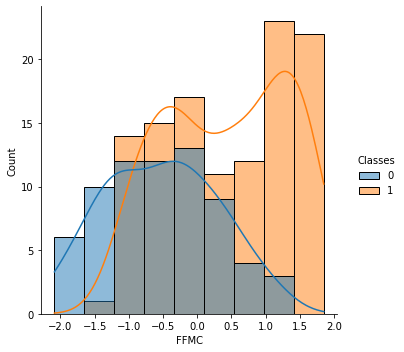

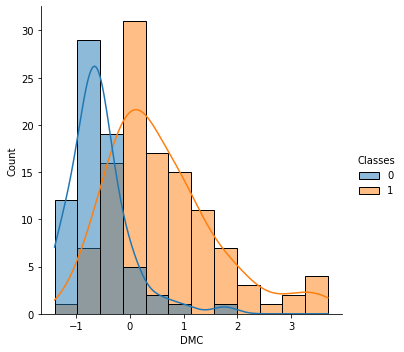

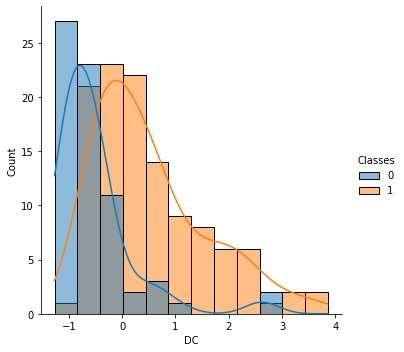

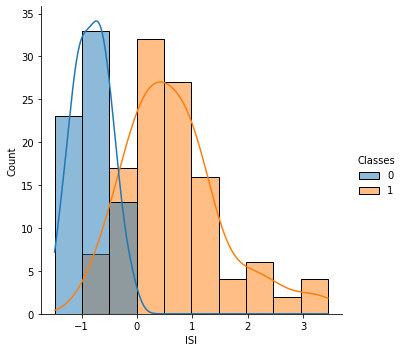

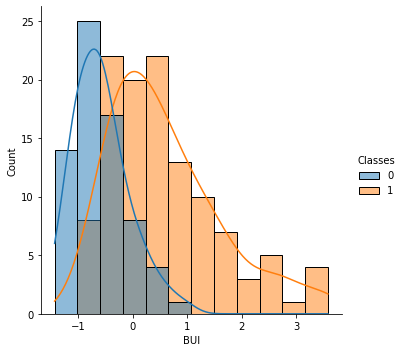

In [128]:
# data visualization
train_df = df.loc[train_idx, feat_cols+[tar_col]]

for col in feat_cols:
    _ = sns.displot(train_df, x=col, hue=tar_col, kde=True)
    plt.savefig("./figs/hist_{}.png".format(col), dpi=200)
    plt.show()

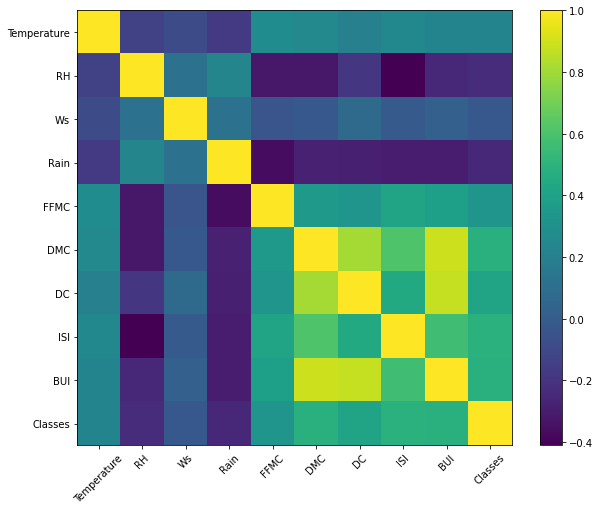

In [104]:
# features correlation
corr = df.loc[:, feat_cols+[tar_col]].corr()
_ = plt.figure(figsize=(10, 8))
_ = plt.imshow(corr)
_ = plt.colorbar()
_ = plt.xticks(np.arange(len(feat_cols+[tar_col])), feat_cols+[tar_col], rotation=45)
_ = plt.yticks(np.arange(len(feat_cols+[tar_col])), feat_cols+[tar_col])
_ = plt.savefig("./figs/corr.png", dpi=200)
plt.show()

In [105]:
# time series feature consturction
df, time_cols = add_time_features(df, feat_cols)
df.head()

Date  Temperature        RH        Ws      Rain      FFMC       DMC  \
0  01/06/2012    -1.428822 -0.827333 -0.650548 -0.542151 -0.173436 -1.286009   
1  01/06/2012     0.227105 -0.718350 -0.141711  0.086637 -0.852555 -1.069184   
2  02/06/2012    -1.822265 -0.220204 -0.915161  0.311761 -1.765988 -0.841802   
3  02/06/2012    -0.800850  1.745318  0.475091  1.569748 -2.043659 -0.703813   
4  03/06/2012    -1.383145  1.951330  1.637714  6.205274 -1.943639 -1.276454   

         DC       ISI       BUI  ...  DMC_5mean   DC_5max  DC_5min  DC_5mean  \
0 -0.410135 -0.955678 -0.695594  ...   0.024087  0.647267 -0.58668  0.016766   
1 -1.191452 -1.397439 -0.966293  ...   0.024087  0.647267 -0.58668  0.016766   
2 -1.267797 -0.763704 -1.349082  ...   0.024087  0.647267 -0.58668  0.016766   
3 -1.016855 -1.235771 -1.112458  ...   0.024087  0.647267 -0.58668  0.016766   
4 -1.058197 -0.939670 -1.253355  ...   0.024087  0.647267 -0.58668  0.016766   

   ISI_5max  ISI_5min  ISI_5mean  BUI_5max  BUI_5min  BUI_5mean  
0  1.093169  -0.82575   0.020954  0.662168 -0.621478   0.020765  
1  1.093169  -0.82575   0.020954  0.662168 -0.621478   0.020765  
2  1.093169  -0.82575   0.020954  0.662168 -0.621478   0.020765  
3  1.093169  -0.82575   0.020954  0.662168 -0.621478   0.020765  
4  1.093169  -0.82575   0.020954  0.662168 -0.621478   0.020765  

[5 rows x 38 columns]

## **Logistic Regression**

LogisticRegression(C=1, solver='liblinear')

Best LOGClassifier:  LogisticRegression(C=1, solver='liblinear')
F1-score of LogisticRegression is 0.873
Accuracy of LogisticRegression is 0.883
The confusion matrix of LogisticRegression:


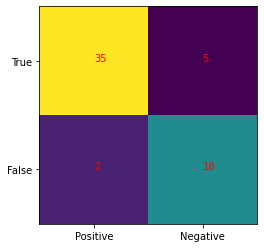

In [115]:
from sklearn.linear_model import LogisticRegression

# train on the original dataset
log_clf = LogisticRegression()
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
log_clfs, log_res_df = finetune(df.loc[train_idx, feat_cols+[tar_col]], feat_cols, tar_col, log_clf, params)
log_res_df.to_csv("./res/ori_log_res.csv", index=False)

# predict on the test dataset
best_log_clf = log_clfs.best_estimator_
best_log_clf.fit(df.loc[train_idx, feat_cols].values, df.loc[train_idx, tar_col].values)
log_f1, log_acc, log_cnf = get_clf_metrics(df.loc[test_idx, feat_cols+[tar_col]], feat_cols, test_y, best_log_clf)

print("Best LOGClassifier: ", log_clfs.best_estimator_)
print("F1-score of LogisticRegression is {:.3f}".format(log_f1))
print("Accuracy of LogisticRegression is {:.3f}".format(log_acc))
print("The confusion matrix of LogisticRegression:")
plot_cnf(log_cnf, name='ori_log')

LogisticRegression(C=0.1, penalty='l1', solver='saga')

Best LOGClassifier:  LogisticRegression(C=0.1, penalty='l1', solver='saga')
F1-score of LogisticRegression is 0.876
Accuracy of LogisticRegression is 0.883
The confusion matrix of LogisticRegression:


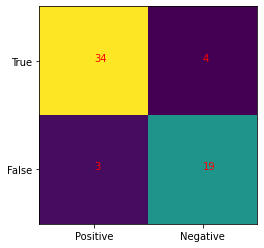

In [116]:
# train on the augmented dataset
log_clf = LogisticRegression()
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
log_clfs, log_res_df = finetune(df.loc[train_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, tar_col, log_clf, params)
log_res_df.to_csv("./res/aug_log_res.csv", index=False)

# predict on the test dataset
best_log_clf = log_clfs.best_estimator_
best_log_clf.fit(df.loc[train_idx, feat_cols+time_cols].values, df.loc[train_idx, tar_col].values)
log_f1, log_acc, log_cnf = get_clf_metrics(df.loc[test_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, test_y, best_log_clf)

print("Best LOGClassifier: ", log_clfs.best_estimator_)
print("F1-score of LogisticRegression is {:.3f}".format(log_f1))
print("Accuracy of LogisticRegression is {:.3f}".format(log_acc))
print("The confusion matrix of LogisticRegression:")
plot_cnf(log_cnf, name='aug_log')

## **Support Vector Machine**

SVC(C=1, kernel='linear')

Best SVMClassifier:  SVC(C=1, kernel='linear')
F1-score of SupportVectorMachine is 0.911
Accuracy of SupportVectorMachine is 0.917
The confusion matrix of SupportVectorMachine:


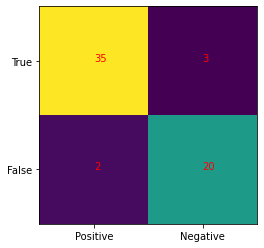

In [117]:
from sklearn.svm import SVC

# train on the original dataset
svm_clf = SVC()
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_clfs, svm_res_df = finetune(df.loc[train_idx, feat_cols+[tar_col]], feat_cols, tar_col, svm_clf, params)
svm_res_df.to_csv("./res/ori_svm_res.csv", index=False)

# predict on the test dataset
best_svm_clf = svm_clfs.best_estimator_
best_svm_clf.fit(df.loc[train_idx, feat_cols].values, df.loc[train_idx, tar_col].values)
svm_f1, svm_acc, svm_cnf = get_clf_metrics(df.loc[test_idx, feat_cols+[tar_col]], feat_cols, test_y, best_svm_clf)

print("Best SVMClassifier: ", svm_clfs.best_estimator_)
print("F1-score of SupportVectorMachine is {:.3f}".format(svm_f1))
print("Accuracy of SupportVectorMachine is {:.3f}".format(svm_acc))
print("The confusion matrix of SupportVectorMachine:")
plot_cnf(svm_cnf, name='ori_svm')

SVC(C=1, gamma='auto', kernel='sigmoid')

Best SVMClassifier:  SVC(C=1, gamma='auto', kernel='sigmoid')
F1-score of SupportVectorMachine is 0.850
Accuracy of SupportVectorMachine is 0.867
The confusion matrix of SupportVectorMachine:


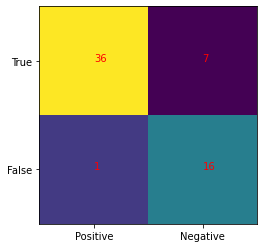

In [118]:
# train on the augmented dataset
svm_clf = SVC()
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_clfs, svm_res_df = finetune(df.loc[train_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, tar_col, svm_clf, params)
svm_res_df.to_csv("./res/aug_svm_res.csv", index=False)

# predict on the test dataset
best_svm_clf = svm_clfs.best_estimator_
best_svm_clf.fit(df.loc[train_idx, feat_cols+time_cols].values, df.loc[train_idx, tar_col].values)
svm_f1, svm_acc, svm_cnf = get_clf_metrics(df.loc[test_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, test_y, best_svm_clf)

print("Best SVMClassifier: ", svm_clfs.best_estimator_)
print("F1-score of SupportVectorMachine is {:.3f}".format(svm_f1))
print("Accuracy of SupportVectorMachine is {:.3f}".format(svm_acc))
print("The confusion matrix of SupportVectorMachine:")
plot_cnf(svm_cnf, name='aug_svm')

## **Neural Networks**

MLPClassifier(activation='tanh', alpha=0.5, learning_rate='adaptive')

Best MLPClassifier:  MLPClassifier(activation='tanh', alpha=0.5, learning_rate='adaptive')
F1-score of NeuralNetwork is 0.873
Accuracy of NeuralNetwork is 0.883
The confusion matrix of NeuralNetwork:


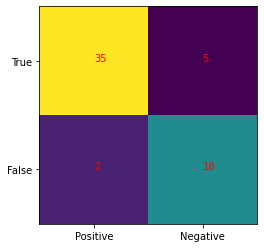

In [119]:
from sklearn.neural_network import MLPClassifier

# train on the original dataset
mlp_clf = MLPClassifier()
params = {'activation':['tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'], 'alpha':[0.001, 0.01, 0.1, 0.5]}
mlp_clfs, mlp_res_df = finetune(df.loc[train_idx, feat_cols+[tar_col]], feat_cols, tar_col, mlp_clf, params)
mlp_res_df.to_csv("./res/ori_mlp_res.csv", index=False)

# predict on the test dataset
best_mlp_clf = mlp_clfs.best_estimator_
best_mlp_clf.fit(df.loc[train_idx, feat_cols].values, df.loc[train_idx, tar_col].values)
mlp_f1, mlp_acc, mlp_cnf = get_clf_metrics(df.loc[test_idx, feat_cols+[tar_col]], feat_cols, test_y, best_mlp_clf)

print("Best MLPClassifier: ", mlp_clfs.best_estimator_)
print("F1-score of NeuralNetwork is {:.3f}".format(mlp_f1))
print("Accuracy of NeuralNetwork is {:.3f}".format(mlp_acc))
print("The confusion matrix of NeuralNetwork:")
plot_cnf(mlp_cnf, name='ori_mlp')

MLPClassifier(activation='tanh', alpha=0.001)

Best MLPClassifier:  MLPClassifier(activation='tanh', alpha=0.001)
F1-score of NeuralNetwork is 0.890
Accuracy of NeuralNetwork is 0.900
The confusion matrix of NeuralNetwork:


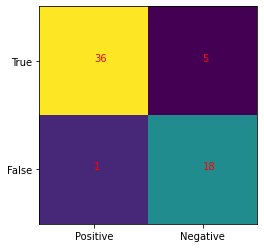

In [121]:
# train on the augmented dataset
mlp_clf = MLPClassifier()
params = {'activation':['tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'], 'alpha':[0.001, 0.01, 0.1, 0.5]}
mlp_clfs, mlp_res_df = finetune(df.loc[train_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, tar_col, mlp_clf, params)
mlp_res_df.to_csv("./res/aug_mlp_res.csv", index=False)

# predict on the test dataset
best_mlp_clf = mlp_clfs.best_estimator_
best_mlp_clf.fit(df.loc[train_idx, feat_cols+time_cols].values, df.loc[train_idx, tar_col].values)
mlp_f1, mlp_acc, mlp_cnf = get_clf_metrics(df.loc[test_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, test_y, best_mlp_clf)

print("Best MLPClassifier: ", mlp_clfs.best_estimator_)
print("F1-score of NeuralNetwork is {:.3f}".format(mlp_f1))
print("Accuracy of NeuralNetwork is {:.3f}".format(mlp_acc))
print("The confusion matrix of NeuralNetwork:")
plot_cnf(mlp_cnf, name='aug_mlp')

## **Trivial System**

Mean accuracy on validation dataset: 0.462
Std accuracy on validation dataset: 0.045
F1-score of TrivialClassifier is 0.482
Accuracy of TrivialClassifier is 0.400
The confusion matrix of TrivialClassifier:


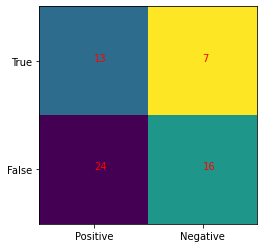

In [125]:
from model import TrivialClassifier

# train on the original dataset
trv_clf = TrivialClassifier()
mean_val, std_val = cross_val(df.loc[train_idx, feat_cols+[tar_col]], feat_cols, tar_col, trv_clf)
print("Mean accuracy on validation dataset: {:.3f}".format(mean_val))
print("Std accuracy on validation dataset: {:.3f}".format(std_val))

# predict on the test dataset

trv_acc = trv_clf.score(df.loc[test_idx, feat_cols].values, test_y)
y_pred = trv_clf.predict(df.loc[test_idx, feat_cols].values)
trv_f1 = f1_score(test_y, y_pred, average='macro')
trv_cnf = confusion_matrix(test_y, y_pred)
print("F1-score of TrivialClassifier is {:.3f}".format(trv_f1))
print("Accuracy of TrivialClassifier is {:.3f}".format(trv_acc))
print("The confusion matrix of TrivialClassifier:")
plot_cnf(trv_cnf, name='ori_trv')

## **Baseline: Nearest Mean Classifier**

Mean accuracy on validation dataset: 0.864
Std accuracy on validation dataset: 0.084
F1-score of KernelNearestMeansClassifier is 0.762
Accuracy of KernelNearestMeansClassifier is 0.800
The confusion matrix of KernelNearestMeansClassifier:


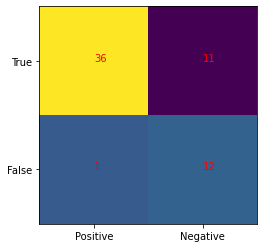

In [126]:
from model import KernelNearestMeansClassifier

# train on the original dataset
knm_clf = KernelNearestMeansClassifier()
mean_val, std_val = cross_val(df.loc[train_idx, feat_cols+[tar_col]], feat_cols, tar_col, knm_clf)
print("Mean accuracy on validation dataset: {:.3f}".format(mean_val))
print("Std accuracy on validation dataset: {:.3f}".format(std_val))

# predict on the test dataset

knm_acc = knm_clf.score(df.loc[test_idx, feat_cols].values, test_y)
y_pred = knm_clf.predict(df.loc[test_idx, feat_cols].values)
knm_f1 = f1_score(test_y, y_pred, average='macro')
knm_cnf = confusion_matrix(test_y, y_pred)
print("F1-score of KernelNearestMeansClassifier is {:.3f}".format(knm_f1))
print("Accuracy of KernelNearestMeansClassifier is {:.3f}".format(knm_acc))
print("The confusion matrix of KernelNearestMeansClassifier:")
plot_cnf(knm_cnf, name='ori_knm')

Mean accuracy on validation dataset: 0.771
Std accuracy on validation dataset: 0.093
F1-score of KernelNearestMeansClassifier is 0.692
Accuracy of KernelNearestMeansClassifier is 0.733
The confusion matrix of KernelNearestMeansClassifier:


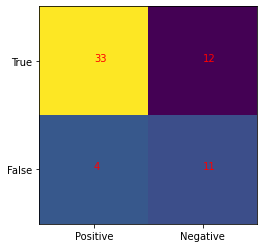

In [127]:
# train on the augmented dataset
knm_clf = KernelNearestMeansClassifier()
mean_val, std_val = cross_val(df.loc[train_idx, feat_cols+time_cols+[tar_col]], feat_cols+time_cols, tar_col, knm_clf)
print("Mean accuracy on validation dataset: {:.3f}".format(mean_val))
print("Std accuracy on validation dataset: {:.3f}".format(std_val))

# predict on the test dataset

knm_acc = knm_clf.score(df.loc[test_idx, feat_cols+time_cols].values, test_y)
y_pred = knm_clf.predict(df.loc[test_idx, feat_cols+time_cols].values)
knm_f1 = f1_score(test_y, y_pred, average='macro')
knm_cnf = confusion_matrix(test_y, y_pred)
print("F1-score of KernelNearestMeansClassifier is {:.3f}".format(knm_f1))
print("Accuracy of KernelNearestMeansClassifier is {:.3f}".format(knm_acc))
print("The confusion matrix of KernelNearestMeansClassifier:")
plot_cnf(knm_cnf, name='aug_knm')

## **Feature Importance**

<Figure size 864x432 with 0 Axes>

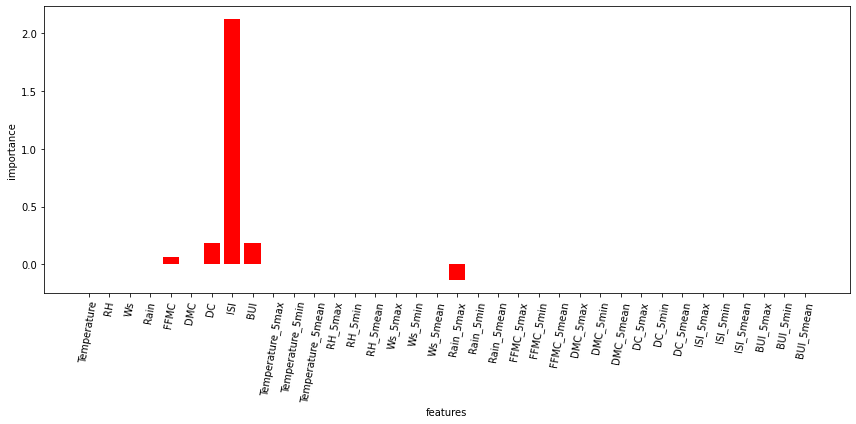

In [113]:
importance = best_log_clf.coef_[0]
plt.figure(figsize=(12, 6))
_ = plt.bar([x for x in range(len(importance))], importance, color='red')
_ = plt.xticks(ticks=list(range(len(importance))), labels=feat_cols+time_cols, rotation=80)
_ = plt.xlabel("features")
_ = plt.ylabel("importance")
_ = plt.tight_layout()
_ = plt.savefig("./figs/imp_log.png", dpi=300)
_ = plt.show()
